In [16]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import trustworthiness
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

With the block I gave you we minimise the aggregate absolute z-score, so we deliberately pick the patient whose feature-vector sits closest to the centre of its own class distribution. That makes them the most typical

In [17]:
# CONSTANTS

EXCEL_PATH = "NEW_Miyokardit_08.12.2025.xlsx"
LABEL_COL  = "GRUP"
EPS        = 1e-12          # to avoid taking log2(0)
N_BINS = 20                 # for discretisizing features

In [18]:
# HELPERS

def kl_divergence(p, q, eps=EPS):
    """
    D_KL(p || q)
    """
    union_idx = p.index.union(q.index) # combine all unique values from both p and q
    p, q = p.reindex(union_idx, fill_value=0), q.reindex(union_idx, fill_value=0) # ensures both series have the same indices. Missing ones are replaced by 0
    return float(np.sum(p * np.log2((p + eps) / (q + eps))))

def get_distribution(series):
    # get the PMF of a feature
    return series.value_counts(normalize=True)

def discretise(series):
    # PMF might be near continuous so get_distribution would create 1/N tiny spikes in the dist.
    ## seperate into 20 bins
    if series.nunique() > N_BINS*2: # if more than N_BINS*2 unique values
            return pd.qcut(series, q=N_BINS, duplicates="drop") # EXPLAIN WHY YOU USE THIS AND NOT pd.cut
    return series

def shannon_entropy(p, eps=EPS):
    """H(p)  (base-2).  `p` is a pandas Series whose values sum to 1."""
    return float(-np.sum(p * np.log2(p + eps)))

def js_divergence(p, q, eps=EPS):
    """
    Jensen-Shannon divergence.
    Symmetric, bounded in [0, 1] when log base is 2.
    """
    union = p.index.union(q.index)
    p, q = p.reindex(union, fill_value=0), q.reindex(union, fill_value=0)
    m = 0.5 * (p + q)
    kl_p_m = np.sum(p * np.log2((p + eps) / (m + eps)))
    kl_q_m = np.sum(q * np.log2((q + eps) / (m + eps)))
    return 0.5 * (kl_p_m + kl_q_m)


In [19]:
import pandas as pd

df = pd.read_excel(EXCEL_PATH)

LABEL_COL = "GRUP"

# ------------------------------------------------------------
# 0) Önce LABEL kolonunu ayır
# ------------------------------------------------------------
label_series = df[LABEL_COL]

# ------------------------------------------------------------
# 1) Feature seçimi (B..Z ve AD..AU)
# ------------------------------------------------------------
df_part1 = df.iloc[:, 1:26]   # B..Z
df_part2 = df.iloc[:, 29:47]  # AD..AU
df = pd.concat([df_part1, df_part2], axis=1)

print("After feature selection shape:", df.shape)

# ------------------------------------------------------------
# 2) Hidden NaN temizliği
# ------------------------------------------------------------
df = df.replace([" ", "", "-", "--", "nan", "NaN", "None"], pd.NA)
df = df.apply(lambda col: col.replace(r'^\s*$', pd.NA, regex=True))

# ------------------------------------------------------------
# 3) Datetime kolonlarını sil
# ------------------------------------------------------------
datetime_cols = df.select_dtypes(include=["datetime"]).columns
df = df.drop(columns=datetime_cols)

# ------------------------------------------------------------
# 4) Numeric’e çevrilebilen kolonları numeric yap
# ------------------------------------------------------------
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ------------------------------------------------------------
# 5) GRUP kolonunu geri ekle
# ------------------------------------------------------------
df[LABEL_COL] = label_series

# ------------------------------------------------------------
# 6) ⬅️ ÖNCE NaN içeren SATIRLARI çıkar
# ------------------------------------------------------------
initial_rows = len(df)
df = df.dropna(axis=0)
final_rows = len(df)

print(f"Removed {initial_rows - final_rows} rows due to missing values.")
print(f"Remaining rows: {final_rows}")

# ------------------------------------------------------------
# 7) ⬅️ SONRA NaN içeren KOLONLARI sil (LABEL hariç)
# ------------------------------------------------------------
nan_counts = df.isna().sum()
cols_to_drop = nan_counts[(nan_counts > 0) & (nan_counts.index != LABEL_COL)].index
df_clean = df.drop(columns=cols_to_drop)

print(f"Dropped {len(cols_to_drop)} feature columns due to NaN.")
print("Remaining shape after column drops:", df_clean.shape)

# ------------------------------------------------------------
# 8) Feature listesi (LABEL_COL hariç)
# ------------------------------------------------------------
features = [c for c in df_clean.columns if c != LABEL_COL]

# ------------------------------------------------------------
# 9) Sınıf dağılımını hesapla
# ------------------------------------------------------------
final_class_counts = df_clean[LABEL_COL].value_counts().sort_index()

print("\nClass distribution:")
for label, count in final_class_counts.items():
    print(f"  Class {label}: {count} patients")

After feature selection shape: (184, 43)
Removed 18 rows due to missing values.
Remaining rows: 166
Dropped 0 feature columns due to NaN.
Remaining shape after column drops: (166, 44)

Class distribution:
  Class 1: 68 patients
  Class 2: 98 patients


In [20]:
dist      = {}       # {feat: (p_class1, p_class2)}
entropy   = {}       # {feat: {1: H1 , 2: H2}}
js        = {}       # {feat: JS}

for feat in features:
    col_disc = discretise(df[feat])
    p1 = get_distribution(col_disc[df[LABEL_COL] == 1])
    p2 = get_distribution(col_disc[df[LABEL_COL] == 2])

    dist[feat]    = (p1, p2)
    entropy[feat] = {1: shannon_entropy(p1),
                     2: shannon_entropy(p2)}
    js[feat]      = max(js_divergence(p1, p2), EPS)    # never let it be 0

stats = {feat: {
             1: {"mu": df.loc[df[LABEL_COL] == 1, feat].mean(),
                 "std": df.loc[df[LABEL_COL] == 1, feat].std(ddof=0) + EPS},
             2: {"mu": df.loc[df[LABEL_COL] == 2, feat].mean(),
                 "std": df.loc[df[LABEL_COL] == 2, feat].std(ddof=0) + EPS}}
         for feat in features}


In [21]:
N          = 4                 # ← set the number you want
RND_STATE  = 42                 # fixed seed ⇒ reproducible

rng = np.random.default_rng(RND_STATE)
holdout_idx = rng.choice(df.index, size=N, replace=False).tolist()

print("Hold-out rows:", holdout_idx)

# ------------------------------------------------------------------
#  Split data
# ------------------------------------------------------------------
df_holdout = df.loc[[87, 20, 123, 141]].copy()
df_train   = df.drop(index=[87, 20, 123, 141])

print(f"Training set : {len(df_train)} rows")
print(f"Hold-out set : {len(df_holdout)} rows")

Hold-out rows: [87, 20, 123, 141]
Training set : 162 rows
Hold-out set : 4 rows


In [22]:
## GOOD RANDOMS:
#Hold-out rows: [69, 13, 103, 121]
#Training set : 155 rows
#Hold-out set : 4 rows

In [23]:
df_holdout

,AGE,SEX,DM,HT,HL,FH,SIGARA,KBY,PRIOR_KAH,KOAH,...,HTC,PLT,KREATIN,AST,ALT,TOTAL_KOLESTEROL,TG,LDL,HDL,GRUP
87,28,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44.0,306.0,0.81,22.0,24.0,187.0,180.0,119.0,32.0,2
20,32,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.0,171.0,1.11,29.0,24.0,116.0,162.0,63.0,21.0,1
123,41,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,45.0,306.0,0.80,17.0,33.0,208.0,193.0,128.0,41.0,2
141,41,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,44.0,245.0,0.70,18.0,28.0,167.0,322.0,64.0,39.0,2


In [24]:
df_train

,AGE,SEX,DM,HT,HL,FH,SIGARA,KBY,PRIOR_KAH,KOAH,...,HTC,PLT,KREATIN,AST,ALT,TOTAL_KOLESTEROL,TG,LDL,HDL,GRUP
2,19,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,35.0,243.0,0.63,22.0,13.0,147.0,71.0,106.0,27.0,1
3,26,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,35.6,509.0,0.72,14.0,17.0,107.0,84.0,47.0,43.0,1
4,19,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,45.7,225.0,0.87,48.0,31.0,156.0,95.0,94.0,43.0,1
5,21,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,43.0,204.0,0.74,59.0,25.0,163.0,143.0,113.0,21.0,1
6,55,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,43.0,201.0,0.80,34.0,17.0,179.0,176.0,118.0,26.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,44,1,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,41.0,300.0,0.90,22.0,31.0,211.0,164.0,141.0,37.0,2
180,44,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,48.0,270.0,0.87,34.0,39.0,201.0,446.0,273.0,34.0,2
181,45,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,43.0,174.0,0.70,51.0,26.0,254.0,234.0,170.0,37.0,2
182,44,0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,38.0,249.0,0.80,21.0,20.0,110.0,75.0,54.0,41.0,2


In [25]:
df = df_train

# GET THE UNCERTAINTY MATRIX

# 3-a) Distributions, entropies (per class) and JS divergence (per feature)
dist      = {}       # {feat: (p_class1, p_class2)}
entropy   = {}       # {feat: {1: H1 , 2: H2}}
js        = {}       # {feat: JS}

for feat in features:
    col_disc = discretise(df[feat])
    p1 = get_distribution(col_disc[df[LABEL_COL] == 1])
    p2 = get_distribution(col_disc[df[LABEL_COL] == 2])

    dist[feat]    = (p1, p2)
    entropy[feat] = {1: shannon_entropy(p1),
                     2: shannon_entropy(p2)}
    js[feat]      = max(js_divergence(p1, p2), EPS)    # never let it be 0

# 3-b) Means & stds for z-scores  (ddof=0 ⇒ population σ)
stats = {feat: {
             1: {"mu": df.loc[df[LABEL_COL] == 1, feat].mean(),
                 "std": df.loc[df[LABEL_COL] == 1, feat].std(ddof=0) + EPS},
             2: {"mu": df.loc[df[LABEL_COL] == 2, feat].mean(),
                 "std": df.loc[df[LABEL_COL] == 2, feat].std(ddof=0) + EPS}}
         for feat in features}

# ------------------------------------------------------------------
# 4. Build the patient × feature matrix
# ------------------------------------------------------------------
rows = []        # list of X-vectors
for _, patient in df.iterrows():
    vec = []
    for feat in features:
        v = patient[feat]

        # z-scores vs. each class
        z1 = (v - stats[feat][1]["mu"]) / stats[feat][1]["std"]
        z2 = (v - stats[feat][2]["mu"]) / stats[feat][2]["std"]

        # pick the *magnitude-wise* smaller one
        if abs(z1) < abs(z2):
            z  = z1
            cls = 1
        else:
            z  = z2
            cls = 2

        h      = entropy[feat][cls]       # Shannon entropy of the chosen class
        js_f   = js[feat]                 # JS divergence for this feature
        x_f    = z * (1.0 / (js_f + EPS)) * h

        vec.append(x_f)
    rows.append(vec)

X_matrix = pd.DataFrame(rows, index=df.index, columns=features)

In [26]:
X_matrix

,AGE,SEX,DM,HT,HL,FH,SIGARA,KBY,PRIOR_KAH,KOAH,...,HB,HTC,PLT,KREATIN,AST,ALT,TOTAL_KOLESTEROL,TG,LDL,HDL
2,-3.619856,-215.261610,-0.356344,-0.975374,-0.000000,-0.0,1.773342,-0.0,-0.000000,-0.000000,...,-13.583171,-25.851084,-2.734505,-17.303782,-11.168727,-27.654144,-0.976181,-9.163204,-6.587602,-24.789874
3,0.645753,-215.261610,-0.356344,-0.975374,-0.000000,-0.0,-4.429711,-0.0,-0.000000,-0.000000,...,-17.537442,-23.581564,99.433950,-8.385920,-16.662728,-22.784689,-16.831723,-5.978387,-23.587375,18.141863
4,-3.619856,37.765195,-0.356344,-0.975374,-0.000000,-0.0,1.773342,-0.0,-0.000000,-0.000000,...,3.360524,6.716262,-9.648160,0.299682,4.477214,5.920268,2.591316,-3.283542,2.409188,18.141863
5,-2.401111,37.765195,-0.356344,-0.975374,-0.000000,-0.0,1.773342,-0.0,-0.000000,-0.000000,...,0.692699,-1.096533,-17.714091,-6.404172,13.092637,-11.564461,5.366036,-6.609698,-4.570679,-40.889276
6,18.317563,37.765195,-0.356344,-0.975374,-0.000000,-0.0,1.773342,-0.0,-0.000000,-0.000000,...,0.485582,-1.096533,-18.866367,-0.458931,-2.927724,-22.784689,-2.020275,-3.833519,-3.130021,-27.473108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,4.943000,37.765195,37.231047,8.972879,70.122232,-0.0,1.773342,-0.0,16.184076,-0.000000,...,-8.307389,-3.155876,15.072587,3.646126,-11.168727,5.920268,7.806344,-4.843039,3.497010,2.042461
180,4.943000,37.765195,-0.356344,-0.975374,-0.000000,-0.0,1.773342,-0.0,-0.000000,56.190447,...,2.915886,13.371605,0.224031,0.299682,-2.927724,3.997314,4.735526,18.880678,41.530400,-6.007239
181,6.175507,37.765195,-0.356344,-0.975374,-0.000000,-0.0,1.773342,-0.0,-0.000000,-0.000000,...,0.485582,-1.096533,-29.236849,-10.367667,6.826875,-8.650339,21.010865,1.045827,11.852830,2.042461
182,4.943000,-215.261610,37.231047,8.972879,-0.000000,-0.0,1.773342,-0.0,16.184076,-0.000000,...,-17.100360,-14.503480,-0.429954,-0.458931,-11.855477,-19.132598,-15.642557,-8.183260,-21.570452,12.775396


In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_matrix)

X_scaled.shape

(162, 43)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 34.8 MB/s eta 0:00:00


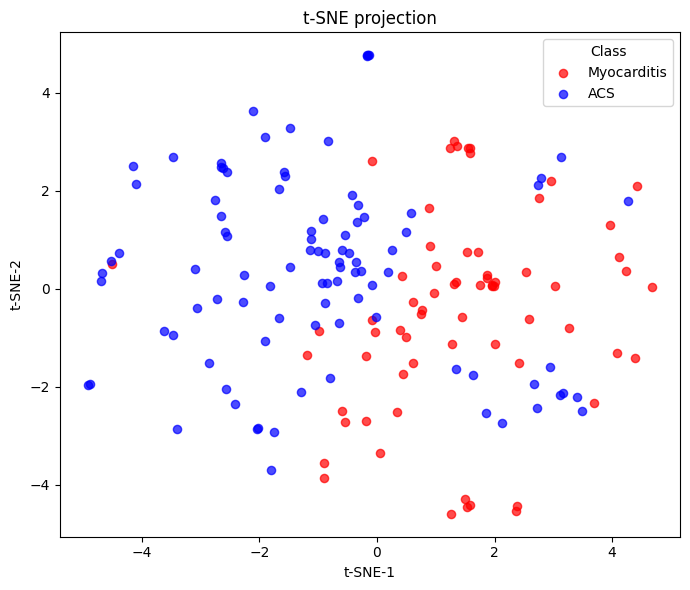

In [28]:
!pip install openTSNE
from openTSNE import TSNE

tsne = TSNE(n_components=2, perplexity=50, early_exaggeration=12.0,
            learning_rate='auto', initialization='pca', random_state=42)

X_tsne = tsne.fit(X_scaled)

labels = df[LABEL_COL]  # 1 or 2

plt.figure(figsize=(7,6))

# Plot each class separately with label for legend
for cls, color in zip([1, 2], ['red', 'blue']):
    idx = labels == cls
    if cls == 1:
        plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                c=color, label=f'Myocarditis', s=35, alpha=0.7)
    if cls == 2:
        plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                c=color, label=f'ACS', s=35, alpha=0.7)


plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.title(f't-SNE projection')
plt.legend(title="Class", loc='best')
plt.tight_layout()
plt.savefig("tSNE.pdf", dpi=300)
plt.show()

In [29]:
rows_h = []
for _, patient in df_holdout.iterrows():    # df_holdout was set aside earlier
    vec = []
    for feat in features:
        v   = patient[feat]
        z1  = (v - stats[feat][1]["mu"]) / stats[feat][1]["std"]
        z2  = (v - stats[feat][2]["mu"]) / stats[feat][2]["std"]
        if abs(z1) < abs(z2):
            z, cls = z1, 1
        else:
            z, cls = z2, 2
        h        = entropy[feat][cls]
        js_f     = js[feat]
        vec.append(z * (1.0 / (js_f + EPS)) * h)
    rows_h.append(vec)

X_holdout = pd.DataFrame(rows_h, index=df_holdout.index, columns=features)


In [30]:
X_holdout

,AGE,SEX,DM,HT,HL,FH,SIGARA,KBY,PRIOR_KAH,KOAH,...,HB,HTC,PLT,KREATIN,AST,ALT,TOTAL_KOLESTEROL,TG,LDL,HDL
87,1.864499,37.765195,-0.356344,-0.975374,-0.0,-0.000000,-4.429711,-0.0,-0.0,-0.0,...,1.137336,1.797095,18.042298,0.531943,-11.168727,-14.478582,0.436379,-3.497012,-2.841889,-11.373706
20,4.301990,37.765195,-0.356344,-0.975374,-0.0,-0.000000,-4.429711,-0.0,-0.0,-0.0,...,-8.307389,-10.720945,-30.389125,27.071238,-6.361475,-14.478582,-13.264226,-5.011292,-17.213886,-40.889276
123,1.245480,37.765195,-0.356344,-0.975374,-0.0,-0.000000,1.773342,-0.0,-0.0,-0.0,...,2.915886,4.690723,18.042298,-0.458931,-14.602478,-3.306869,6.885099,-2.403366,-0.248703,12.775396
141,1.245480,37.765195,-0.356344,-0.975374,-0.0,94.703101,1.773342,-0.0,-0.0,-0.0,...,0.485582,1.797095,-1.966321,-10.367667,-13.915728,-2.822097,-5.705258,8.448973,-16.580884,7.408928


In [31]:
X_holdout_scaled = scaler.transform(X_holdout)
X_holdout_tsne   = X_tsne.transform(X_holdout_scaled)   # <-- new points

In [32]:
X_holdout_tsne

PartialTSNEEmbedding([[-0.66475229, -0.85836288],
                      [ 2.09267363, -0.0133452 ],
                      [-0.46538719,  0.52130711],
                      [-4.90143318, -2.04914562]])

In [33]:
plt.rcParams["figure.figsize"] = (7, 6)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 12


In [34]:
# Padding around extreme points so contours don't touch the frame
pad = 2.0

xmin, xmax = X_tsne[:, 0].min() - pad, X_tsne[:, 0].max() + pad
ymin, ymax = X_tsne[:, 1].min() - pad, X_tsne[:, 1].max() + pad

# 250×250 grid (adjust for speed ↔ smoothness)
resolution = 1000
xs = np.linspace(xmin, xmax, resolution)
ys = np.linspace(ymin, ymax, resolution)
xx, yy = np.meshgrid(xs, ys)
grid = np.vstack([xx.ravel(), yy.ravel()])

class1 = X_tsne[labels == 1]
class2 = X_tsne[labels == 2]

kde1 = gaussian_kde(class1.T, bw_method="scott")
kde2 = gaussian_kde(class2.T, bw_method="scott")

z1 = kde1(grid).reshape(xx.shape)
z2 = kde2(grid).reshape(xx.shape)

q = 0.6                                                     # 60 % iso-density
level1 = np.quantile(z1, q)
level2 = np.quantile(z2, q)

overlap = (z1 >= level1) & (z2 >= level2)

# --- 6.  Build alpha masks & colour-shift for the overlap -----------------
def normalise(z, clip=0.98):
    """Scale density field to 0–1, clipping the top `clip` quantile."""
    zmax = np.quantile(z, clip)
    return np.clip(z / zmax, 0, 1)

# -------------------------------------------------------------------------
# 1) Alpha masks for the *pure* class regions (same idea as before)
# -------------------------------------------------------------------------
alpha1 = normalise(z1)**0.5
alpha2 = normalise(z2)**0.5
alpha1[z1 < level1] = 0.0
alpha2[z2 < level2] = 0.0

# -------------------------------------------------------------------------
# 2) Identify the overlap and give it its own alpha map
# -------------------------------------------------------------------------
overlap_mask      = (alpha1 > 0) & (alpha2 > 0)
alpha_overlap     = np.maximum(alpha1, alpha2)
alpha_overlap[~overlap_mask] = 0.0

# Remove the red/blue alphas *inside* the overlap so they don't sit on top
alpha1[overlap_mask] = 0.0
alpha2[overlap_mask] = 0.0

# -------------------------------------------------------------------------
# 3) Per-pixel colour for the overlap
#    • Start from mid-grey  (0.5, 0.5, 0.5)
#    • Shift toward red or blue according to local dominance
# -------------------------------------------------------------------------
eps   = 1e-12                    # avoid division by zero
total = z1 + z2 + eps
t     = (z1 - z2) / total        # -1 ⟶ pure blue side, +1 ⟶ pure red side

shift_strength = 0.3    # 0 → always grey, base_gray → full red/blue at edge

# Base: all grey
R = np.full_like(t, 0.5)
G = np.full_like(t, 0.5)
B = np.full_like(t, 0.5)

# Shift toward red where t > 0
pos          = t > 0
R[pos] += shift_strength * t[pos]
G[pos] -= shift_strength * t[pos]
B[pos] -= shift_strength * t[pos]

# Shift toward blue where t < 0
neg          = t < 0
B[neg] += shift_strength * (-t[neg])
R[neg] -= shift_strength * (-t[neg])
G[neg] -= shift_strength * (-t[neg])

shape = (*alpha1.shape, 4)        # (Ny, Nx, 4)

red_img  = np.zeros(shape)
red_img[..., 0] = 1.0             # R channel
red_img[..., 3] = alpha1          # alpha   (class-1 density)

blue_img = np.zeros(shape)
blue_img[..., 2] = 1.0            # B channel
blue_img[..., 3] = alpha2         # alpha   (class-2 density)

# Build the RGBA image for the overlap
shape      = (*alpha_overlap.shape, 4)
over_img   = np.zeros(shape)
over_img[..., 0] = R
over_img[..., 1] = G
over_img[..., 2] = B
over_img[..., 3] = alpha_overlap        # density-weighted fade-out

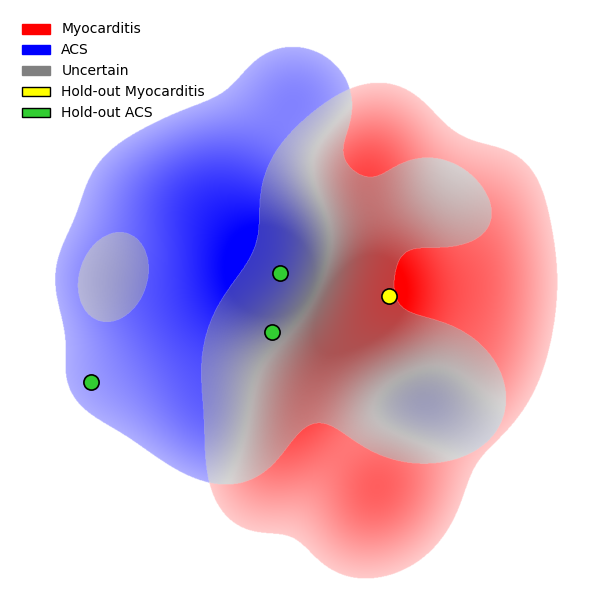

In [35]:
# --- Plot, final clean look ----------------------------------------------
fig, ax = plt.subplots()

# 🔧 1)  ⟵  **REMOVE** the scatter-plot calls
# for cls, color, label in [(1, "red", "Myocarditis"),
#                           (2, "blue", "ACS")]:
#     idx = labels == cls
#     ax.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
#                c=color, s=35, alpha=0.7, label=label)

# Filled RGBA layers (unchanged)
for img in [over_img, red_img, blue_img]:
    ax.imshow(img, extent=(xmin, xmax, ymin, ymax), origin="lower", interpolation="bilinear")

dot_col = {1: "yellow",   # myocarditis hold-out
           2: "limegreen"}  # ACS hold-out  (limegreen reads better than pure green)

for point, lbl in zip(X_holdout_tsne, df_holdout[LABEL_COL].values):
    ax.scatter(point[0], point[1],
               c=dot_col[lbl],
               s=120,
               marker="o",
               edgecolors="k",
               linewidths=1.2,
               zorder=15)          # sit on top of density layers

# 🔧 2)  ⟵  **COMMENT-OUT** the three outline-contour lines if you haven’t already
# ax.contour(...)
# ax.contour(...)
# ax.contour(...)

# 🔧 3)  ⟵  **Hide the entire axes frame** (ticks, spines, labels)
ax.set_axis_off()          # ‘off’ removes ticks, spines and axis labels

# 🔧 4)  ⟵  **Remove the overall title** (and legend, if not useful anymore)
# ax.set_title("t-SNE projection — filled regions only")   # ← delete / comment
# ax.legend_.remove()   # uncomment this line if a legend still exists

from matplotlib.patches import Patch   # add at the top of the cell if not imported

# ── proxy artists just for the legend ────────────────────────────
legend_handles = [
    Patch(facecolor="red",  edgecolor="red",  label="Myocarditis"),
    Patch(facecolor="blue", edgecolor="blue", label="ACS"),
    Patch(facecolor="gray", edgecolor="gray", label="Uncertain")
]

legend_handles += [
    Patch(facecolor="yellow",   edgecolor="k", label="Hold-out Myocarditis"),
    Patch(facecolor="limegreen", edgecolor="k", label="Hold-out ACS")
]

ax.legend(handles=legend_handles, loc="upper left", frameon=False)

plt.tight_layout()
plt.savefig("case_study.pdf", dpi=300)
plt.show()
